In [24]:
import numpy as np
from os import path
import matplotlib.pyplot as plt

In [25]:
### 1.1. Load data

# imresps.npy is of shape (1573, 2, 15363), where 1573 is number of images, 2 repeats each, and 15363 neurons recorded
# stimids.npy has the image id (matching the image dataset ~selection1866~) for each stimulus number, 
# so of you want to see what image was presented on imresps[502] you would check stim_ids[502]

PATH_TO_DATA = '../../data/neural'

imresps = np.load(path.join(PATH_TO_DATA, 'imresps.npy'))
stimids = np.load(path.join(PATH_TO_DATA, 'stimids.npy'))

print(imresps.shape) # (1573, 2, 15363)
print(stimids.shape) # (1573,)

(1573, 2, 15363)
(1573,)


In [26]:
def compute_signal_related_variance(resp_a, resp_b, mean_center=True):
    """
    compute the fraction of signal-related variance for each neuron,
    as per Stringer et al Nature 2019. Cross-validated by splitting
    responses into two halves. Note, this only is "correct" if resp_a
    and resp_b are *not* averages of many trials.

    Args:
        resp_a (ndarray): n_stimuli, n_cells
        resp_b (ndarray): n_stimuli, n_cells

    Returns:
        fraction_of_stimulus_variance: 0-1, 0 is non-stimulus-caring, 1 is only-stimulus-caring neurons
        stim_to_noise_ratio: ratio of the stim-related variance to all other variance
    """
    if len(resp_a.shape) > 2:
        # if the stimulus is multi-dimensional, flatten across all stimuli
        resp_a = resp_a.reshape(-1, resp_a.shape[-1])
        resp_b = resp_b.reshape(-1, resp_b.shape[-1])
    ns, nc = resp_a.shape
    if mean_center:
        # mean-center the activity of each cell
        resp_a = resp_a - resp_a.mean(axis=0)
        resp_b = resp_b - resp_b.mean(axis=0)
    
    # compute the cross-trial stimulus covariance of each cell
    # dot-product each cell's (n_stim, ) vector from one half
    # with its own (n_stim, ) vector on the other half

    covariance = (resp_a * resp_b).sum(axis=0) / ns

    # compute the variance of each cell across both halves
    resp_a_variance = (resp_a**2).sum(axis=0) / ns
    resp_b_variance = (resp_b**2).sum(axis=0) / ns
    total_variance = (resp_a_variance + resp_b_variance) / 2

    if np.any(total_variance < 1e-12):
        print(f"Warning: Near-zero total variance for neurons: {np.where(total_variance < 1e-12)[0]}")

    # compute the fraction of the total variance that is
    # captured in the covariance
    fraction_of_stimulus_variance = covariance / total_variance

    # if you want, you can compute SNR as well:
    stim_to_noise_ratio = fraction_of_stimulus_variance / (
        1 - fraction_of_stimulus_variance
    )

    return fraction_of_stimulus_variance, stim_to_noise_ratio

[-0.01405032  0.00563386 -0.00393842 ...  0.00283485  0.03396848
  0.00109324]
[-0.00771612  0.01272217  0.02783848 ... -0.00460037 -0.02699663
 -0.01463046]


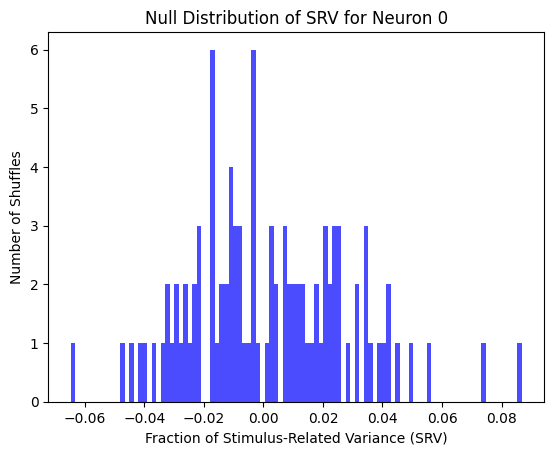

In [27]:
### 2.1. Compute the null distribution of SRV values for all neurons

# imresps shape = (1573, 2, 15363)
# responses in imresps shape = (2, 15363)
num_stimuli = imresps.shape[0] # 1573
num_repeats = imresps.shape[1] # 2
num_neurons = imresps.shape[2] # 15363
n_shuffles = 100

null_srv_all_neurons = [] # shape (n_shuffles, num_neurons)

# TODO: Question for Ali: I wrestled with this for a long time, need to check with you that this is correct
for _ in range(n_shuffles):
    # Shuffle stimulus indices *twice* to create two independent splits!
    shuffled_indices_A = np.random.permutation(num_stimuli)
    shuffled_indices_B = np.random.permutation(num_stimuli)

    # Now for the splits, we can just use fixed repeat indices, 
    # because for each split, at index N the responses correspond to different stimuli
    # e.g. split_A = [ stim_100_repeat_1, stim_2_repeat_1, stim_19_repeat_1, ... ]
    # e.g. split_B = [ stim_543_repeat_2, stim_345_repeat_2, stim_3_repeat_2, ... ]
    split_A = imresps[shuffled_indices_A, 0, :]
    split_B = imresps[shuffled_indices_B, 1, :]

    # Compute SRV for the shuffled data
    fraction_of_stimulus_variance, _ = compute_signal_related_variance(split_A, split_B)
    null_srv_all_neurons.append(fraction_of_stimulus_variance)

null_srv_all_neurons = np.array(null_srv_all_neurons)
null_srv_all_neurons.shape # (100, 15363)

print(null_srv_all_neurons[0])
print(null_srv_all_neurons[33])

# e.g. if neuron_index = 0, it will plot the SRV value for neuron 0 across all shuffles
neuron_index = 0
plt.hist([srv[neuron_index] for srv in null_srv_all_neurons], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title(f"Null Distribution of SRV for Neuron {neuron_index}")
plt.show()

In [28]:
### 2.2. Compute the real SRV for each neuron

# TODO: Question for Ali: why can't we just split like this?
# split_A_real = imresps[:, 0, :] # First repeat for each stimulus
# split_B_real = imresps[:, 1, :] # Second repeat for each stimulus

split_A, split_B = [], []
for responses in imresps: # responses shape: (2, n_neurons)
    indices = np.random.permutation(2) # Randomly shuffle [0, 1]
    split_A.append(responses[indices[0]]) # Assign one repeat to split_A
    split_B.append(responses[indices[1]]) # Assign the other to split_B

split_A = np.array(split_A)  # Shape: (n_stimuli, n_neurons)
split_B = np.array(split_B)  # Shape: (n_stimuli, n_neurons)

# Compute SRV for real data
real_srv_all_neurons, stim_to_noise_ratio = compute_signal_related_variance(split_A, split_B)

print(real_srv_all_neurons)
print(stim_to_noise_ratio)

print("Real SRV shape:", real_srv_all_neurons.shape) # Should be (15363,)

[-0.02861872 -0.00798034 -0.0369001  ...  0.2055491   0.03237264
  0.02293871]
[-0.02782248 -0.00791715 -0.03558694 ...  0.25873103  0.03345569
  0.02347724]
Real SRV shape: (15363,)


In [29]:
### 2.3. Filter neurons whose real SRV is in the top 90th percentile of its null distribution

# This gives the 90th-percentile SRV value of the null distribution for each neuron
# In other words the threshold for each neuron to be considered reliable
# e.g. if neuron 0 has a null distribution of SRVs across 10 shuffles 
# [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], the threshold would be 0.9
top_90th_percentile_null = np.percentile(null_srv_all_neurons, 90, axis=0)
print(top_90th_percentile_null) # [0.03651716 0.03126347 0.03325775 ... 0.02738261 0.03546677 0.0333109 ]

# Get indices of reliable neurons
reliable_neuron_indices = np.where(real_srv_all_neurons >= top_90th_percentile_null)[0]

# Print results
print(f"Number of reliable neurons: {len(reliable_neuron_indices)}") # 5654
print(f"Indices of reliable neurons: {reliable_neuron_indices}") # [   14    29    48 ... 15357 15358 15360]

[0.03488563 0.03414452 0.03378783 ... 0.02303155 0.03161538 0.01869257]
Number of reliable neurons: 5630
Indices of reliable neurons: [   14    48    70 ... 15360 15361 15362]


Labels: tensor([ 1.,  2.,  3.,  4.,  5.,  7.,  8.,  9., 10., 11.], dtype=torch.float64)
Processed dataset shape: torch.Size([1573, 3, 224, 224])
Min pixel value (processed): -0.9981953501701355
Max pixel value (processed): 0.9988274574279785


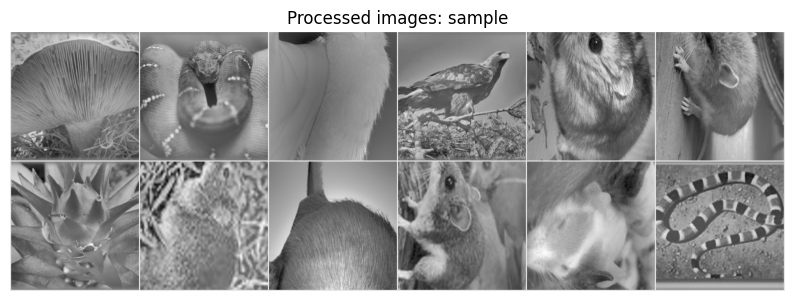

In [40]:
### 3.1. Load and preprocess images

import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Normalize, Compose, Resize, CenterCrop
import torch
from torch.utils.data import TensorDataset
from torchvision import utils as torch_utils
 
PATH_TO_DATA = '../../data/selection1866'

file_list = sorted(f for f in os.listdir(PATH_TO_DATA) if f.endswith('.mat'))
stim_ids = stimids.astype(int)

print(stim_ids)
print(stimids)

# Prepare images for SimCLR; TODO careful, STL10 is 96x96
# TODO: run tile 1 and 2 through model separately + concat feature reps (no crop, pad)
transform = Compose([
    Resize(224), # Resize shortest edge to 224 (cut off the rightmost part of the image)
    CenterCrop((224, 224)), # Crop to (224, 224)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # !! Normalize expects input is already in the range [0, 1]
])

img_tensors, labels = [], []

# TODO: is this ok? For the regression, the input-output dimensions must match
# we have 1866 images here, but the neural response data only uses 1573 of them
# there we filter the full set here so that we only use the relevant 1573
for stim_id in stimids:
    filename = file_list[stim_id]
    data = loadmat(os.path.join(PATH_TO_DATA, filename))

# for idx, filename in enumerate(filtered_file_list):
#     data = loadmat(os.path.join(PATH_TO_DATA, filename))
    
    img = data['img'][:, :500] # Take leftmost part of the image
    rgb_img = np.stack([img] * 3, axis=-1) # Convert grayscale to RGB for SimCLR
    tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
    
    # Min-max scale the tensor to [0, 1]
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    tensor = (tensor - tensor_min) / (tensor_max - tensor_min)

    # Clamp to [0, 1] to ensure no outliers due to numerical precision
    tensor = torch.clamp(tensor, 0.0, 1.0)

    transformed_tensor = transform(tensor) # Normalize and resize for SimCLR
    img_tensors.append(transformed_tensor)
    labels.append(stim_id)

image_dataset = TensorDataset(torch.stack(img_tensors), torch.tensor(labels))

images, labels = image_dataset.tensors
print("Labels:", labels[:10])
print("Processed dataset shape:", images.shape) # (N, C, 96, 96)
print(f"Min pixel value (processed): {torch.min(images)}")
print(f"Max pixel value (processed): {torch.max(images)}")

# Show a sample of processed images
img_grid = torch_utils.make_grid(images[:12], nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.title('Processed images: sample')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [31]:
### 3.2. Run images through a pretrained SimCLR model and extract features

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from tqdm.notebook import tqdm
from typing import Dict
from torch.utils.data import Dataset
import urllib.request
from urllib.error import HTTPError

class SimCLR(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Base ResNet18 backbone (pretrained=False, because we load custom weights later, from the SimCLR checkpoint file)
        self.convnet = torchvision.models.resnet18(pretrained=False)
        
        # This is the projection head, only needed during training. For downstream tasks it is disposed of
        # and the final linear layer output is used (Chen et al., 2020) 
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        self.intermediate_layers_to_capture =[]
        self.intermediate_layer_features = {}
        self.num_workers = os.cpu_count()
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    def load_pretrained(self):
        """
        Load pretrained SimCLR weights
        """
        base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
        models_dir = "../../models"
        pretrained_simclr_filename = "SimCLR.ckpt"
        pretrained_simclr_path = os.path.join(models_dir, pretrained_simclr_filename)
        os.makedirs(models_dir, exist_ok=True)

        # Check whether the pretrained model file already exists locally. If not, try downloading it
        file_url = base_url + pretrained_simclr_filename
        if not os.path.isfile(pretrained_simclr_path):
            print(f"Downloading pretrained SimCLR model {file_url}...")
            try:
                urllib.request.urlretrieve(file_url, pretrained_simclr_path)
            except HTTPError as e:
                print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

        print(f"Already downloaded pretrained model: {file_url}")

        # Load pretrained model
        checkpoint = torch.load(pretrained_simclr_path, map_location=self.device)
        self.load_state_dict(checkpoint['state_dict'])
        self.to(self.device)
        self.eval()

    def set_intermediate_layers_to_capture(self, layers):
        """
        Register hooks to capture features from intermediate layers
        """
        # Just check the layers specified are actually in the convnet
        top_level_block_layers = [name for name, _ in self.convnet.named_children()]
        if not all(layer in top_level_block_layers for layer in layers):
            print('You have specified convnet layers that are not top-level blocks - make sure your layer names are valid')
        
        self.intermediate_layers_to_capture = layers
        intermediate_layer_features = {}

        def get_hook(layer_name):
            def hook(module, input, output):
                intermediate_layer_features[layer_name] = output.detach()
            return hook

        for layer_name in layers:
            layer = dict([*self.convnet.named_modules()])[layer_name]
            layer.register_forward_hook(get_hook(layer_name))

        self.intermediate_layer_features = intermediate_layer_features

    @torch.no_grad()
    def extract_features(self, dataset: Dataset) -> Dict[str, torch.Tensor]:
        """
        Run the pretrained SimCLR model on the image data, and capture features from final layer and intermediate layers.

        Args:
            dataset (Dataset): A PyTorch Dataset containing input images and labels. The image data should have shape (N, C, H, W)

        Returns:
            Dict[str, torch.Tensor]: A dictionary containing:
                - Intermediate layer features as tensors.
                - Final layer features under 'final_layer'.
                - Labels under 'labels'.
            Features from a given layer has shape (N, F) where N is num images, F is number of features - flattened version of (C, H, W).
        """
        self.convnet.fc = nn.Identity()  # Removing projection head g(.)
        self.eval()
        self.to(self.device)
        
        # Encode all images
        data_loader = DataLoader(dataset, batch_size=64, num_workers=self.num_workers, shuffle=False, drop_last=False)
        feats, labels, intermediate_features = [], [], {layer: [] for layer in self.intermediate_layers_to_capture}

        for batch_imgs, batch_labels in tqdm(data_loader):
            batch_imgs = batch_imgs.to(self.device)
            batch_feats = self.convnet(batch_imgs)
            
            feats.append(batch_feats.detach().cpu())
            labels.append(batch_labels)
            
            # Collect intermediate layer outputs
            for layer in self.intermediate_layers_to_capture:
                # Final linear layer outputs a 2d tensor; but intermediate layers don't, so we flatten them (ready for PCA etc.)
                layer_output_flattened = self.intermediate_layer_features[layer].view(self.intermediate_layer_features[layer].size(0), -1) 
                intermediate_features[layer].append(layer_output_flattened.cpu())
        
        # Concatenate results for each layer
        feats = torch.cat(feats, dim=0)
        labels = torch.cat(labels, dim=0)
        intermediate_features = {layer: torch.cat(intermediate_features[layer], dim=0) for layer in self.intermediate_layers_to_capture}

        return {**intermediate_features, 'final_layer': feats, 'labels': labels}

intermediate_layers = ['layer1', 'layer2', 'layer3', 'layer4']

sim_clr = SimCLR()
sim_clr.load_pretrained()
sim_clr.set_intermediate_layers_to_capture(intermediate_layers)
feats = sim_clr.extract_features(image_dataset)

layer1_feats = feats['layer1'] # Shape: torch.Size([600, 200704])
layer2_feats = feats['layer2']
layer3_feats = feats['layer3']
layer4_feats = feats['layer4']
final_layer_feats = feats['final_layer'] # Shape: torch.Size([600, 512])

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/_c/21m3vmjd7c1_75f4nxmg1k480000gn/T/ipykernel_2170/673593334.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECU

Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


  0%|          | 0/30 [00:00<?, ?it/s]

First 10 labels in SimCLR features: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


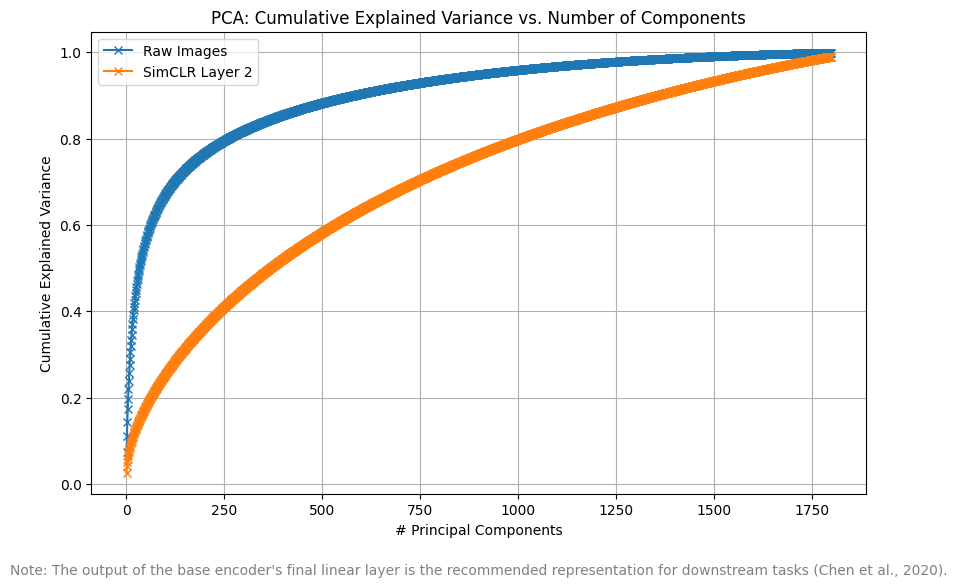

In [32]:
### 3.3. Apply PCA to SimCLR representations

from sklearn.decomposition import PCA

num_components = 1800

# TODO note: cross-validation, and subsampling of each layer, is done in notebooks/003_experiment_images/experiment_images.ipynb
def run_pca(data, num_components=num_components, flatten_data=False):
    data = data.view(data.size(0), -1) if flatten_data else data

    pca = PCA(n_components=num_components)
    pca.fit(data)
    explained_variance = pca.explained_variance_ratio_
    return np.cumsum(explained_variance), explained_variance

print("First 10 labels in SimCLR features:", labels[:10])

cumulative_ev_raw, ev_raw = run_pca(images, flatten_data=True)
cumulative_ev_layer2, ev_layer2 = run_pca(layer2_feats)

# Plot cumulative explained var vs. # principal components
plot_components = range(1, num_components + 1)
plt.figure(figsize=(10, 6))
plt.plot(plot_components, cumulative_ev_raw, label="Raw Images", marker='x')
plt.plot(plot_components, cumulative_ev_layer2, label="SimCLR Layer 2", marker='x')
plt.xlabel("# Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance vs. Number of Components")
plt.legend()
plt.text(
    0.5, -0.15,  # X and Y coordinates
    "Note: The output of the base encoder's final linear layer is the recommended representation for downstream tasks (Chen et al., 2020).",
    fontsize=10,
    color="gray",
    ha="center",
    va="top",
    transform=plt.gca().transAxes
)
plt.grid(True)
plt.show()

In [33]:
### 3.4. Choose principal components that explain a % of variance e.g. 90%.

# Ensure the number of features is not vastly greater than the number of neurons to reduce overfitting.
# We have 5654 reliable neurons

def get_num_components_for_variance(cumulative_variance, target_variance=0.9):
    index_of_pc_reaching_target_var = np.argmax(cumulative_variance >= target_variance)
    
    if(index_of_pc_reaching_target_var == 0):
        print(f"Warning: The computed PCs do not cumulatively explain {target_variance * 100}% variance")
    
    return index_of_pc_reaching_target_var + 1 # Add 1 because indices start at 0

# Get the number of PCs for 90% variance
num_pcs_raw = get_num_components_for_variance(cumulative_ev_raw, target_variance=0.9)
num_pcs_layer2 = get_num_components_for_variance(cumulative_ev_layer2, target_variance=0.9)

print(f"Number of PCs explaining 90% variance (Raw Images): {num_pcs_raw}") # 580
print(f"Number of PCs explaining 90% variance (SimCLR Layer 2): {num_pcs_layer2}") # 1356

# Raw Images: 580 / 5654 ≈ 0.10 → 0.1 feature-to-sample ratio (good)
# SimCLR Layer 2: 1356 / 5654 ≈ 0.24 → 0.24 feature-to-sample ratio (good especially with regularisation)

Number of PCs explaining 90% variance (Raw Images): 580
Number of PCs explaining 90% variance (SimCLR Layer 2): 1356


In [34]:
### 3.4. Project the data into PCA space

# TODO: I do not know what I am doing here, ChatGPT gave me the code. I should study this

## 3.4.1. For raw images
flattened_images = images.view(images.shape[0], -1) # Shape: [1866, 150528]
pca_raw = PCA(n_components=num_pcs_raw)
pca_raw.fit(flattened_images)
raw_image_pcs = pca_raw.transform(flattened_images) # Shape: (1573, 580) -> 1573 images, 580 PCs

## 3.4.2. For layer-2 activations
pca_layer2 = PCA(n_components=num_pcs_layer2)
pca_layer2.fit(layer2_feats)
layer2_pcs = pca_layer2.transform(layer2_feats) # Shape: (1573, 1356) -> 1573 images, 1356 PCs

In [38]:
### 4.1. Regression per neuron

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Gather the neural responses for the reliable neurons
# TODO: we take the average across repeats for each neuron - is this right?
neural_responses = imresps[:, :, reliable_neuron_indices] # Shape: (1573, 2, 5654)
neural_responses_mean = neural_responses.mean(axis=1)  # Shape: (1573, 5654) -> 1573 images, 5654 neurons

# Select a specific reliable neuron by index (because we will have a regression model per neuron)
reliable_neuron_index = reliable_neuron_indices[0]
mean_response_single_neuron = neural_responses_mean[:, reliable_neuron_index]  # Shape: (1573,)

## 4.1.1. For raw images

print('Raw image PCs shape', raw_image_pcs.shape) # (1866, 580)
print('Mean response single neuron shape', mean_response_single_neuron.shape) # (1573,)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(raw_image_pcs, mean_response_single_neuron, test_size=0.2, random_state=42)

# Train the linear regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Evaluate the model
score = reg.score(X_test, y_test)
print(f"R^2 Score for Neuron {neuron_index}: {score}")

## 4.1.2. For SimCLR layer 2 features

Raw image PCs shape (1866, 580)
Mean response single neuron shape (1573,)


ValueError: Found input variables with inconsistent numbers of samples: [1866, 1573]